[Previous: ARIMA-models](09-ARIMA-models.ipynb)
• [Contents](Contents.ipynb)

# 10 | Dynamic regression models

[FPP3 Chapter 10](https://otexts.com/fpp3/dynamic.html)

* [10.1 Estimation](#10.1-Estimation)
* [10.2 Regression with ARIMA errors in ~R~ Python](#10.2-Regression-with-ARIMA-errors-in-R-Python)
* [10.3 Forecasting](#10.3-Forecasting)
* [10.4 Stochastic and deterministic trends](#10.4-Stochastic-and-deterministic-trends)
* [10.5 Dynamic harmonic regression](#10.5-Dynamic-harmonic-regression)
* [10.6 Lagged predictors](#10.6-Lagged-predictors)

<hr/>

In [1]:
import sys
sys.path.insert(0, '.')
from utils import *

[utils.py](utils.py)

## 10.1 Estimation

[FPP3 Section 10.1](https://otexts.com/fpp3/estimation.html)

## 10.2 Regression with ARIMA errors in ~R~ Python

[FPP3 Section 10.2](https://otexts.com/fpp3/regarima.html)

In [2]:
us_change = pd.read_csv('data/fpp3/us_change.csv')
us_change = (
    us_change
    .assign(date=pd.to_datetime(us_change.Quarter.str.replace(' ', '')))
    .set_index('date')
    .pipe(set_freq)
)

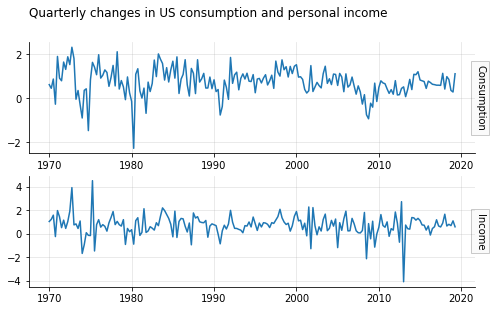

In [3]:
fig, axs = plt.subplots(2)
axs[0].plot(us_change.Consumption)
rlabel(axs[0], 'Consumption')
axs[1].plot(us_change.Income)
rlabel(axs[1], 'Income')
suptitle('Quarterly changes in US consumption and personal income')
for ax in axs:
    ax.grid()

In [4]:
split = us_change.index.max() + pd.to_timedelta('1d')
d = extend_timeseries(us_change, 'today')
dtrain, dtest = d[:split], d[split:]

In [5]:
fit = sm.tsa.statespace.SARIMAX(dtrain.Consumption, dtrain.Income, order=(1,0,2), trend='c').fit()

In [6]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            Consumption   No. Observations:                  198
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -163.036
Date:                Sat, 21 Sep 2024   AIC                            338.072
Time:                        21:06:15   BIC                            357.802
Sample:                    01-01-1970   HQIC                           346.058
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1742      0.062      2.788      0.005       0.052       0.297
Income         0.1976      0.034      5.855      0.000       0.131       0.264
ar.L1          0.7071      0.106      6.659      0.000       0.499       0.915
ma.L1         -0.6173      0.113     -5.470      0.000      -0.839      -0.396
ma.L2          0.2066      0.065      3.174      0.002       0.079       0.334
sigma2         0.3035      0.022     13.525      0.000       0.260       0.347
===================================================================================
Ljung-Box (Q):                       33.62   Jarque-Bera (JB):                45.83
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

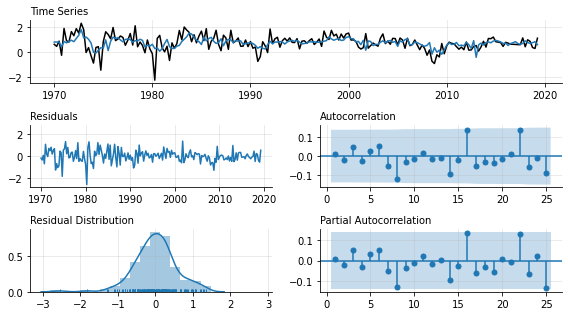

In [7]:
plot_tsresiduals(dtrain.Consumption, fit.fittedvalues);

In [8]:
sm.stats.acorr_ljungbox(
    dtrain.Consumption - fit.fittedvalues, lags=[8], model_df=5, boxpierce=True, return_df=True)

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
8,5.22128,0.156293,4.99043,0.172499


In [9]:
auto_arima_kw = dict(suppress_warnings=True, error_action='ignore', trace=True)

In [10]:
fit = pmd.auto_arima(dtrain.Consumption, dtrain[['Income']], **auto_arima_kw)

Performing stepwise search to minimize aic
Fit ARIMA(2,0,2)x(0,0,0,0) [intercept=True]; AIC=338.516, BIC=361.534, Time=0.093 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=True]; AIC=357.307, BIC=367.172, Time=0.019 seconds
Fit ARIMA(1,0,0)x(0,0,0,0) [intercept=True]; AIC=353.625, BIC=366.778, Time=0.027 seconds
Fit ARIMA(0,0,1)x(0,0,0,0) [intercept=True]; AIC=356.125, BIC=369.278, Time=0.030 seconds
Fit ARIMA(0,0,0)x(0,0,0,0) [intercept=False]; AIC=437.987, BIC=444.564, Time=0.018 seconds
Fit ARIMA(1,0,2)x(0,0,0,0) [intercept=True]; AIC=338.072, BIC=357.802, Time=0.068 seconds
Fit ARIMA(0,0,2)x(0,0,0,0) [intercept=True]; AIC=346.555, BIC=362.997, Time=0.036 seconds
Fit ARIMA(1,0,1)x(0,0,0,0) [intercept=True]; AIC=342.489, BIC=358.931, Time=0.055 seconds
Fit ARIMA(1,0,3)x(0,0,0,0) [intercept=True]; AIC=339.377, BIC=362.395, Time=0.077 seconds
Fit ARIMA(0,0,3)x(0,0,0,0) [intercept=True]; AIC=341.465, BIC=361.195, Time=0.048 seconds
Fit ARIMA(2,0,1)x(0,0,0,0) [intercept=True]; AIC=339.637

In [11]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  198
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -163.036
Date:                Sat, 21 Sep 2024   AIC                            338.072
Time:                        21:06:16   BIC                            357.802
Sample:                    01-01-1970   HQIC                           346.058
                         - 04-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1742      0.062      2.788      0.005       0.052       0.297
Income         0.1976      0.034      5.855      0.000       0.131       0.264
ar.L1          0.7071      0.106      6.659      0.000       0.499       0.915
ma.L1         -0.6173      0.113     -5.470      0.000      -0.839      -0.396
ma.L2          0.2066      0.065      3.174      0.002       0.079       0.334
sigma2         0.3035      0.022     13.525      0.000       0.260       0.347
===================================================================================
Ljung-Box (Q):                       33.62   Jarque-Bera (JB):                45.83
Prob(Q):                              0.75   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

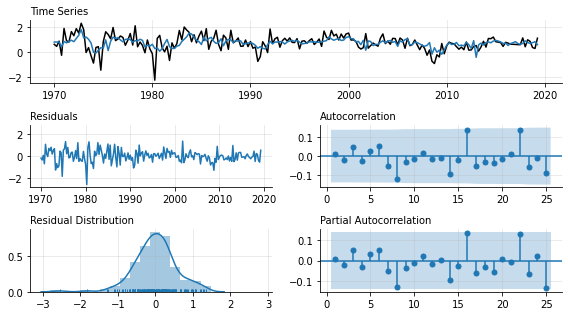

In [12]:
plot_tsresiduals(dtrain.Consumption, fit.arima_res_.fittedvalues);

## 10.3 Forecasting

[FPP3 Section 10.3](https://otexts.com/fpp3/forecasting.html)

### Example: US Personal Consumption and Income

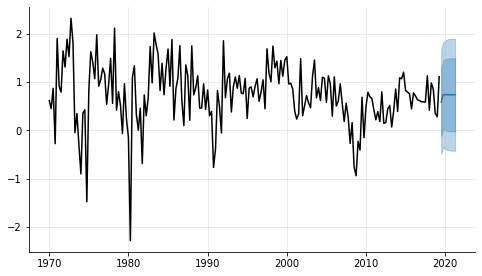

In [13]:
fig, ax = plt.subplots()
ax.plot(us_change.Consumption, 'k')

#ddtest = dtest.assign(Income = dtrain.Income.mean())
#fc = fit.get_forecast(len(ddtest), exog=dtrain.Income)
exog = np.repeat(dtrain.Income.mean(), 8)
fc = fit.arima_res_.get_forecast(len(exog), exog=exog)
ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ax.grid()

### Example: Forecasting electricity demand

**TODO:** doesn't this seem overly complicated?

In [14]:
vic_elec = (
    pd.read_csv('data/tsibbledata/vic_elec.csv', parse_dates=['Time'], infer_datetime_format=True)
    .query('Time.dt.year == 2014')
    .set_index('Time', drop=False)
    .resample('1d')
    .agg(dict(Demand='sum', Temperature='mean', Holiday='any', Time='min'))
    .pipe(compute, lambda x: dict(
        Demand = x.Demand / 1e3,
        DayOfWeek = x.Time.dt.strftime('%A'),
    ))
    .pipe(compute, lambda x: dict(
        Day_Type = np.where(
            x.Holiday,
            'Holiday',
            np.where(
                x.DayOfWeek.isin(['Saturday', 'Sunday']),
                'Weekend',
                'Weekday'
            )
        )
    ))
    .pipe(compute, lambda x: dict(
        Is_Work_Day = x.Day_Type.eq('Weekend')
    ))
    .iloc[:-1] # last day is partial
)
vic_elec

,Temperature,Holiday,Time,Demand,DayOfWeek,Day_Type,Is_Work_Day
Time,,,,,,,
2014-01-01,20.031250,True,2014-01-01,179.453794,Wednesday,Holiday,False
2014-01-02,17.487500,False,2014-01-02,190.778816,Thursday,Weekday,False
2014-01-03,17.718750,False,2014-01-03,182.892121,Friday,Weekday,False
2014-01-04,16.575000,False,2014-01-04,171.285812,Saturday,Weekend,True
2014-01-05,17.606250,False,2014-01-05,179.734300,Sunday,Weekend,True
...,...,...,...,...,...,...,...
2014-12-26,16.429167,True,2014-12-26,168.797125,Friday,Holiday,False
2014-12-27,18.189583,False,2014-12-27,173.292326,Saturday,Weekend,True
2014-12-28,24.539583,False,2014-12-28,196.116229,Sunday,Weekend,True


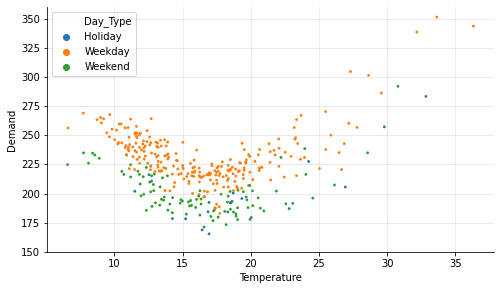

In [15]:
fig, ax = plt.subplots()
d = vic_elec
sns.scatterplot('Temperature', 'Demand', hue='Day_Type', data=d, ax=ax,
                linewidth=0, s=8)
ax.set(ylim=(150, 360))
ax.grid()

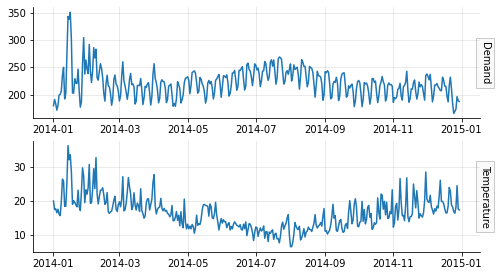

In [16]:
fig, axs = plt.subplots(2)
axs[0].plot(d.Demand)
rlabel(axs[0], 'Demand')
axs[1].plot(d.Temperature)
rlabel(axs[1], 'Temperature')
for ax in axs:
    ax.grid()

In [17]:
d = vic_elec.copy()
d['Temperature2'] = d.Temperature**2
split = d.index.max() + pd.to_timedelta('1h')
d = extend_timeseries(d, dt='28d')
d['Time'] = d.index
dtrain, dtest = d[:split], d[split:]

In [18]:
fit = pmd.auto_arima(
    dtrain.Demand,
    dtrain['Temperature Temperature2 Is_Work_Day'.split()].astype(float),
    **auto_arima_kw)

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=2755.944, BIC=2790.993, Time=0.334 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=2811.725, BIC=2831.197, Time=0.049 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=2811.300, BIC=2834.666, Time=0.101 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=2806.584, BIC=2829.951, Time=0.150 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=2809.728, BIC=2825.305, Time=0.115 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=2760.328, BIC=2791.484, Time=0.277 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=2758.244, BIC=2789.399, Time=0.261 seconds
Fit ARIMA(3,1,2)x(0,0,0,0) [intercept=True]; AIC=2762.198, BIC=2801.142, Time=0.318 seconds
Fit ARIMA(2,1,3)x(0,0,0,0) [intercept=True]; AIC=2711.980, BIC=2750.924, Time=0.391 seconds
Fit ARIMA(1,1,3)x(0,0,0,0) [intercept=True]; AIC=2761.827, BIC=2796.876, Time=0.342 seconds
Fit ARIMA(3,1,3)x(0,0,0,0) [intercep

In [19]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  364
Model:               SARIMAX(2, 1, 3)   Log Likelihood               -1345.990
Date:                Sat, 21 Sep 2024   AIC                           2711.980
Time:                        21:06:21   BIC                           2750.924
Sample:                    01-01-2014   HQIC                          2727.460
                         - 12-30-2014                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept        0.0586      0.235      0.250      0.803      -0.401       0.518
Temperature    -10.3523      0.805    -12.854      0.000     -11.931      -8.774
Temperature2     0.3095      0.018     17.595      0.000       0.275       0.344
Is_Work_Day    -20.6681      1.456    -14.200      0.000     -23.521     -17.815
ar.L1            1.2389      0.006    212.847      0.000       1.227       1.250
ar.L2           -0.9947      0.005   -188.127      0.000      -1.005      -0.984
ma.L1           -1.6571      0.044    -37.543      0.000      -1.744      -1.571
ma.L2            1.4784      0.060     24.480      0.000       1.360       1.597
ma.L3           -0.4060      0.046     -8.786      0.000      -0.497      -0.315
sigma2          95.6872      4.329     22.102      0.000      87.202     104.173
===================================================================================
Ljung-Box (Q):                       63.49   Jarque-Bera (JB):               651.94
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                             0.71
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

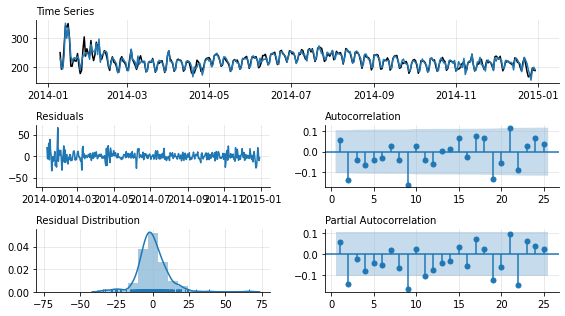

In [20]:
t0 = '2014-01-10'
plot_tsresiduals(dtrain[t0:].Demand, fit.arima_res_.fittedvalues[t0:]);

In [21]:
ddtest = dtest.assign(
    Temperature=26,
    Temperature2=26**2,
    Holiday=np.r_[False, True, np.repeat(False, len(dtest)-2)])
ddtest['Is_Work_Day'] = (
    (~ddtest.Holiday)
    & (~ddtest.Time.dt.day_name().isin(['Saturday', 'Sunday']))
)

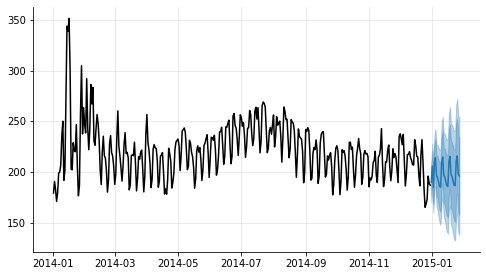

In [22]:
fig, ax = plt.subplots()
ax.plot(dtrain.Demand, 'k')

fc = fit.arima_res_.get_forecast(
    len(ddtest),
    exog=ddtest['Temperature Temperature2 Is_Work_Day'.split()].astype(float))
#exog = np.repeat(dtrain.Income.mean(), 8)
#fc = fit.get_forecast(len(exog), exog=exog)

ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ax.grid()

We can also be a little more specific with our call to `pmdarima.auto_arima()`:

In [23]:
fit2 = pmd.auto_arima(
    dtrain.Demand,
    dtrain['Temperature Temperature2 Is_Work_Day'.split()].astype(float),
    start_P=1, start_Q=1,
    max_P=3, max_Q=3,
    d=0, D=1,
    start_p=1, start_q=1,
    max_p=3, max_q=3, m=7,
    seasonal=True,
    stepwise=True,
    **auto_arima_kw
)

Performing stepwise search to minimize aic
Fit ARIMA(1,0,1)x(1,1,1,7) [intercept=True]; AIC=2607.404, BIC=2642.304, Time=1.208 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=True]; AIC=2893.426, BIC=2912.815, Time=0.062 seconds
Fit ARIMA(1,0,0)x(1,1,0,7) [intercept=True]; AIC=2714.258, BIC=2741.402, Time=0.976 seconds
Fit ARIMA(0,0,1)x(0,1,1,7) [intercept=True]; AIC=2743.821, BIC=2770.965, Time=1.108 seconds
Fit ARIMA(0,0,0)x(0,1,0,7) [intercept=False]; AIC=2891.479, BIC=2906.990, Time=0.133 seconds
Fit ARIMA(1,0,1)x(0,1,1,7) [intercept=True]; AIC=2604.609, BIC=2635.631, Time=1.197 seconds
Near non-invertible roots for order (1, 0, 1)(0, 1, 1, 7); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA(1,0,1)x(1,1,0,7) [intercept=True]; AIC=2704.125, BIC=2735.147, Time=1.551 seconds
Fit ARIMA(1,0,1)x(2,1,1,7) [intercept=True]; AIC=2607.231, BIC=2646.008, Time=6.538 seconds
Near non-invertible roots for order (1, 0, 1)(2, 1, 1, 7); set

In [24]:
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  364
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 7)   Log Likelihood               -1294.305
Date:                           Sat, 21 Sep 2024   AIC                           2604.609
Time:                                   21:07:13   BIC                           2635.631
Sample:                               01-01-2014   HQIC                          2616.948
                                    - 12-30-2014                                         
Covariance Type:                             opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.0125      0.026     -0.479      0.632      -0.064       0.039
Temperature     -9.7984      0.667    -14.692      0.000     -11.106      -8.491
Temperature2     0.2947      0.015     19.808      0.000       0.265       0.324
Is_Work_Day     20.5536      2.677      7.677      0.000      15.306      25.801
ar.L1            0.9143      0.026     34.922      0.000       0.863       0.966
ma.L1           -0.3076      0.051     -6.011      0.000      -0.408      -0.207
ma.S.L7         -0.9871      0.086    -11.433      0.000      -1.156      -0.818
sigma2          76.0033      6.681     11.377      0.000      62.909      89.097
===================================================================================
Ljung-Box (Q):                       51.20   Jarque-Bera (JB):              1029.98
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [25]:
ddtest = dtest.assign(
    Temperature=26,
    Temperature2=26**2,
    Holiday=np.r_[False, True, np.repeat(False, len(dtest)-2)])
ddtest['Is_Work_Day'] = (
    (~ddtest.Holiday)
    & (~ddtest.Time.dt.day_name().isin(['Saturday', 'Sunday']))
)

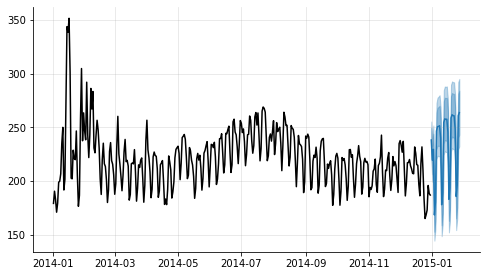

In [26]:
fig, ax = plt.subplots()
ax.plot(dtrain.Demand, 'k')

fc = fit2.arima_res_.get_forecast(
    len(ddtest),
    exog=ddtest['Temperature Temperature2 Is_Work_Day'.split()].astype(float))
#exog = np.repeat(dtrain.Income.mean(), 8)
#fc = fit.get_forecast(len(exog), exog=exog)

ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ax.grid()

## 10.4 Stochastic and deterministic trends

[FPP3 Section 10.4](https://otexts.com/fpp3/stochastic-and-deterministic-trends.html)

### Example: International visitors to Australia

In [27]:
aus_visitors = rdatasets.data('fpp2', 'austa')
aus_visitors = (
    aus_visitors
    .set_index(pd.to_datetime(aus_visitors.time, format='%Y'))
    .pipe(set_freq)
)

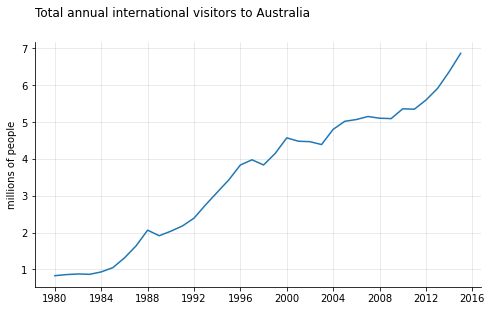

In [28]:
fig, ax = plt.subplots()
ax.plot(aus_visitors.value)
ax.set(ylabel='millions of people')
suptitle('Total annual international visitors to Australia')
ax.grid()

In [29]:
fit = sm.tsa.SARIMAX(aus_visitors.value, trend='ct', order=(2,0,0)).fit()

In [30]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   36
Model:               SARIMAX(2, 0, 0)   Log Likelihood                  14.218
Date:                Sat, 21 Sep 2024   AIC                            -18.436
Time:                        21:07:13   BIC                            -10.519
Sample:                    01-01-1980   HQIC                           -15.673
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1811      0.109      1.669      0.095      -0.032       0.394
drift          0.0462      0.020      2.288      0.022       0.007       0.086
ar.L1          1.1020      0.166      6.621      0.000       0.776       1.428
ar.L2         -0.3631      0.163     -2.226      0.026      -0.683      -0.043
sigma2         0.0256      0.008      3.162      0.002       0.010       0.041
===================================================================================
Ljung-Box (Q):                       15.09   Jarque-Bera (JB):                 0.07
Prob(Q):                              1.00   Prob(JB):                         0.96
Heteroskedasticity (H):               1.67   Skew:                            -0.03
Prob(H) (two-sided):                  0.39   Kurtosis:                         2.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
fit2 = sm.tsa.SARIMAX(aus_visitors.value, trend='c', order=(2,1,0)).fit()

In [32]:
fit2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   36
Model:               SARIMAX(2, 1, 0)   Log Likelihood                  10.710
Date:                Sat, 21 Sep 2024   AIC                            -13.419
Time:                        21:07:13   BIC                             -7.198
Sample:                    01-01-1980   HQIC                           -11.272
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1461      0.050      2.915      0.004       0.048       0.244
ar.L1          0.2910      0.194      1.501      0.133      -0.089       0.671
ar.L2         -0.1373      0.224     -0.613      0.540      -0.576       0.302
sigma2         0.0317      0.012      2.720      0.007       0.009       0.054
===================================================================================
Ljung-Box (Q):                       27.96   Jarque-Bera (JB):                 1.64
Prob(Q):                              0.76   Prob(JB):                         0.44
Heteroskedasticity (H):               1.34   Skew:                            -0.22
Prob(H) (two-sided):                  0.62   Kurtosis:                         2.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

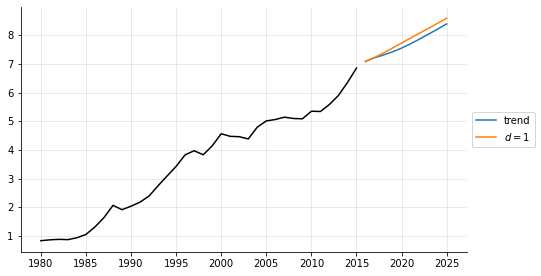

In [33]:
fig, ax = plt.subplots()
ax.plot(aus_visitors.value, 'k')

fc = fit.get_forecast(10)
ax.plot(fc.predicted_mean, label='trend')

fc = fit2.get_forecast(10)
ax.plot(fc.predicted_mean, label='$d=1$')

ax.legend(**legend_right)

ax.grid()

## 10.5 Dynamic harmonic regression

[FPP3 Section 10.5](https://otexts.com/fpp3/dhr.html)

In [34]:
aus_cafe = (
    pd.read_csv('data/tsibbledata/aus_retail.csv', parse_dates=['Month'], infer_datetime_format=True)
    .query('Industry.str.contains("takeaway")')
    .query('Month.dt.year.between(2004, 2018)')
    .groupby('Month').Turnover.sum()
    .pipe(set_freq)
)

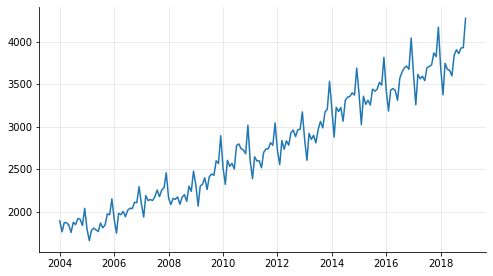

In [35]:
fig, ax = plt.subplots()
ax.plot(aus_cafe)
ax.grid()

In [36]:
fits = {
    k: sm.tsa.UnobservedComponents(
        aus_cafe,
        level=True, trend=True,
        freq_seasonal=[{'period':12,'harmonics':k}]).fit()
    for k in range(1, 7)
}

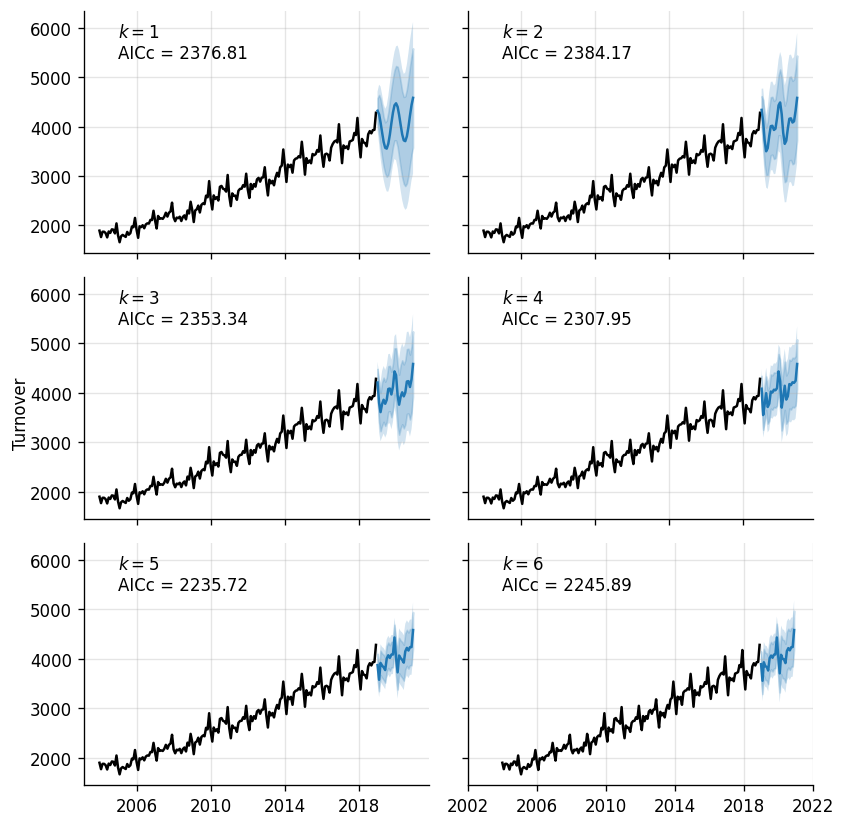

In [37]:
fig, axs = plt.subplots(3, 2, figsize=(7,7), sharex=True, sharey=True, dpi=120)
axs = axs.ravel()
for (ax,(k,fit)) in zip(axs, fits.items()):
    ax.plot(aus_cafe, 'k')
    fc = fit.get_forecast(24)
    ax.plot(fc.predicted_mean)
    ci = ciclean(fc.conf_int())
    ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.2)
    ci = ciclean(fc.conf_int(alpha=.2))
    ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.2, color='C0')
    ax.grid()
    xdate(ax, '%Y', '4ys')
    ax.text(.1, .95, f'$k={k}$\nAICc = {fit.aicc:.2f}', va='top', transform=ax.transAxes)
fig.text(0, .5, 'Turnover', rotation=90, va='center')
plt.tight_layout()

## 10.6 Lagged predictors

[FPP3 Section 10.6](https://otexts.com/fpp3/lagged-predictors.html)

### Example: TV advertising and insurance quotations

In [38]:
d = rdatasets.data('fpp2', 'insurance')
d.columns = 'Quotes', 'TV_advert'
d = d.set_index(pd.date_range('2002-01-01', '2005-04-01', freq='MS'))
d = extend_timeseries(d, dt='1y')
for lag in range(4):
    d[f'advert_{lag}'] = d.TV_advert.shift(lag)
insurance = d = d.dropna()

In [39]:
d.tail(15)

,Quotes,TV_advert,advert_0,advert_1,advert_2,advert_3
2004-02-01,13.63092,9.565460,9.565460,8.010201,6.977100,6.939995
2004-03-01,9.12098,6.272510,6.272510,9.565460,8.010201,6.977100
2004-04-01,8.39468,5.707495,5.707495,6.272510,9.565460,8.010201
2004-05-01,12.30076,7.963540,7.963540,5.707495,6.272510,9.565460
2004-06-01,13.84831,8.494221,8.494221,7.963540,5.707495,6.272510
2004-07-01,15.96246,9.789085,9.789085,8.494221,7.963540,5.707495
2004-08-01,14.19738,8.692825,8.692825,9.789085,8.494221,7.963540
2004-09-01,12.85922,8.057230,8.057230,8.692825,9.789085,8.494221
2004-10-01,12.08837,7.588995,7.588995,8.057230,8.692825,9.789085
2004-11-01,12.93375,8.244881,8.244881,7.588995,8.057230,8.692825


In [40]:
dtrain = d.iloc[:32]
dtest = d.iloc[32:]

In [41]:
%%time
lag0 = pmd.auto_arima(
    dtrain.Quotes, dtrain['advert_0'.split()],
    d=0, suppress_warnings=True)
lag1 = pmd.auto_arima(
    dtrain.Quotes, dtrain['advert_0 advert_1'.split()],
    d=0, suppress_warnings=True)
lag2 = pmd.auto_arima(
    dtrain.Quotes, dtrain['advert_0 advert_1 advert_2'.split()],
    d=0, suppress_warnings=True)
lag3 = pmd.auto_arima(
    dtrain.Quotes, dtrain['advert_0 advert_1 advert_2 advert_3'.split()],
    d=0, suppress_warnings=True)

CPU times: user 2.72 s, sys: 2.13 s, total: 4.85 s
Wall time: 1.68 s


In [42]:
lags = lag0, lag1, lag2, lag3
lags

(ARIMA(order=(1, 0, 1), suppress_warnings=True),
 ARIMA(order=(1, 0, 1), suppress_warnings=True),
 ARIMA(order=(1, 0, 1), suppress_warnings=True),
 ARIMA(order=(1, 0, 1), suppress_warnings=True))

In [43]:
pd.DataFrame([dict(aic=l.aic(), aicc=l.aicc(), bic=l.bic(), fit=l) for l in (lags)])

,aic,aicc,bic,fit
0,59.052931,61.360623,66.381610,"ARIMA(order=(1, 0, 1), suppress_warnings=True)"
1,54.313028,57.673028,63.107444,"ARIMA(order=(1, 0, 1), suppress_warnings=True)"
2,55.468753,60.135420,65.728904,"ARIMA(order=(1, 0, 1), suppress_warnings=True)"
3,56.819785,63.080655,68.545672,"ARIMA(order=(1, 0, 1), suppress_warnings=True)"


In [44]:
fit = lag1.arima_res_
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   32
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -21.157
Date:                Sat, 21 Sep 2024   AIC                             54.313
Time:                        21:07:18   BIC                             63.107
Sample:                    04-01-2002   HQIC                            57.228
                         - 11-01-2004                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3206      0.439      0.731      0.465      -0.539       1.180
advert_0       1.3069      0.103     12.693      0.000       1.105       1.509
advert_1       0.2060      0.107      1.925      0.054      -0.004       0.416
ar.L1          0.7326      0.182      4.025      0.000       0.376       1.089
ma.L1          0.5879      0.222      2.648      0.008       0.153       1.023
sigma2         0.2069      0.066      3.118      0.002       0.077       0.337
===================================================================================
Ljung-Box (Q):                       17.96   Jarque-Bera (JB):                 7.39
Prob(Q):                              0.97   Prob(JB):                         0.02
Heteroskedasticity (H):               2.80   Skew:                            -1.00
Prob(H) (two-sided):                  0.10   Kurtosis:                         4.25
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

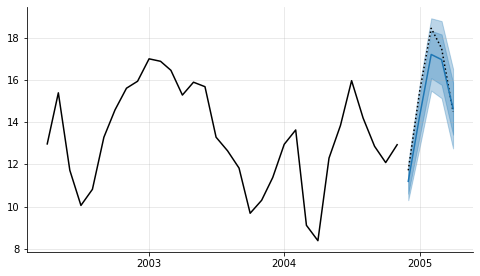

In [45]:
fig, ax = plt.subplots()
ax.plot(dtrain.Quotes, 'k')
ax.plot(dtest.Quotes, 'k:')

fc = fit.get_forecast(
    len(dtest), exog=dtest['advert_0 advert_1'.split()])

ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')

xdate(ax, '%Y', '1ys')
ax.grid()

Or, as done in the book, assume advertising <- 8:

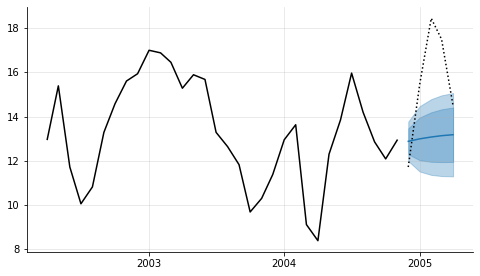

In [46]:
fig, ax = plt.subplots()
ax.plot(dtrain.Quotes, 'k')
ax.plot(dtest.Quotes, 'k:')

fc = fit.get_forecast(
    len(dtest), exog=dtest.assign(advert_0=8, advert_1=8)['advert_0 advert_1'.split()])

ax.plot(fc.predicted_mean)
ci = ciclean(fc.conf_int())
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')
ci = ciclean(fc.conf_int(alpha=.2))
ax.fill_between(ci.index, ci.lower, ci.upper, alpha=.3, color='C0')

xdate(ax, '%Y', '1ys')
ax.grid()

And... well, I guess that's that!

<hr/>

[Previous: ARIMA-models](09-ARIMA-models.ipynb)
• [Contents](Contents.ipynb)